### **ResNet-LSTM Video Classifier for EchoCardio-12**

This is the base image classifier for echonet, and is a resnet-50 with modified fully connected layer, relu and dropout. Trained from zerom as required for good performance.

In [3]:
!python -m venv echo_venv

In [4]:
!ipython kernel install --user --name=echo_venv
!jupyter lab

# SET ENVIRONMENT IN JUPYTER!

Installed kernelspec echo_venv in /home/ubuntu/.local/share/jupyter/kernels/echo_venv
[W 2024-10-29 05:50:31.525 ServerApp] ServerApp.token config is deprecated in 2.0. Use IdentityProvider.token.
[W 2024-10-29 05:50:31.525 ServerApp] ServerApp.allow_password_change config is deprecated in 2.0. Use PasswordIdentityProvider.allow_password_change.
[I 2024-10-29 05:50:31.577 ServerApp] jupyter_collaboration | extension was successfully linked.
[I 2024-10-29 05:50:31.577 ServerApp] jupyter_lsp | extension was successfully linked.
[I 2024-10-29 05:50:31.582 ServerApp] jupyter_server_fileid | extension was successfully linked.
[I 2024-10-29 05:50:31.587 ServerApp] jupyter_server_terminals | extension was successfully linked.
[I 2024-10-29 05:50:31.593 ServerApp] jupyterlab | extension was successfully linked.
[I 2024-10-29 05:50:31.598 ServerApp] notebook | extension was successfully linked.
[I 2024-10-29 05:50:31.795 ServerApp] notebook_shim | extension was successfully linked.
[I 2024-10-2

In [5]:
!python -m pip install wandb poetry opencv-python lightning torchmetrics torch torchvision matplotlib seaborn munch --force

  Using cached wandb-0.18.5-py3-none-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (16.0 MB)
  Using cached poetry-1.8.4-py3-none-any.whl (249 kB)
  Using cached opencv_python-4.10.0.84-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (62.5 MB)
  Using cached lightning-2.4.0-py3-none-any.whl (810 kB)
  Using cached torchmetrics-1.5.1-py3-none-any.whl (890 kB)
  Using cached torch-2.5.0-cp310-cp310-manylinux1_x86_64.whl (906.4 MB)
  Using cached torchvision-0.20.0-cp310-cp310-manylinux1_x86_64.whl (7.2 MB)
  Using cached matplotlib-3.9.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (8.3 MB)
  Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
  Using cached munch-4.0.0-py2.py3-none-any.whl (9.9 kB)
  Using cached PyYAML-6.0.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (751 kB)
  Using cached requests-2.32.3-py3-none-any.whl (64 kB)
  Using cached psutil-6.1.0-cp36-abi3-manylinux_2_12_x86_64.manylinux2010_x86_64.manylinux_2_17_x86_64.manylinux201

### Import Weights and Biases + Login

In [38]:
import wandb

if wandb.run is not None:
  wandb.finish()

wandb.login()

True

### Clone and build dataset

* EchoCardio is too large to download as images, and ships as .mp4 files by default. The 'create_videoset.py' script will split it into frames organized so that it can be loaded as an image, video, or optical-flow dataset.

* The script accepts serval command line arguments for datapath, train/test split, output path, labels, seed, etc. See the code for details.

* The script will by default download the raw dataset, although you can change it via --url. Additionally it will **auto install and use ffmpeg and use that as the main backend, but will install open-cv if available or otherwise specified.**

In [39]:
# !git clone https://github.com/satchelfrench/neo-echoset ./neo_echoset
# !cd ./neo_echoset/ && poetry install --no-ansi

In [40]:
import cv2
import lightning as L

cv2.__version__

# !cd ./neo_echoset/ && poetry run python create_videoset.py --kfold 5

L.seed_everything(7)

Seed set to 7


7

# Transforms

* Sequence wide transforms to correleate features between augmented frames
  


In [41]:
from torchvision.transforms import RandomRotation, RandomAutocontrast, RandomHorizontalFlip, RandomAffine, GaussianBlur
from torchvision.transforms import functional as Fn
from collections.abc import Sequence
from typing import List, Optional, Tuple, Union

import torch
from torch import Tensor

'''
Transform class to apply the same random rotation across all frames in a video sequence
Instead of random rotation to each frame in video.
'''
class RandomSeqRotation(RandomRotation):
    def forward(self, images):
        fill = self.fill
        angle = self.get_params(self.degrees)

        transformed = []

        for img in images:
            channels, _, _ = Fn.get_dimensions(img)

            if isinstance(img, Tensor):
                if isinstance(fill, (int, float)):
                    fill = [float(fill)] * channels
                else:
                    fill = [float(f) for f in fill]
            angle = self.get_params(self.degrees)

            transformed.append(Fn.rotate(img, angle, self.interpolation, self.expand, self.center, fill))

        return transformed

class RandomSeqAffine(RandomAffine):
    def forward(self, images):

        img = images[0]
        fill = self.fill
        channels, height, width = Fn.get_dimensions(img)
        if isinstance(img, Tensor):
            if isinstance(fill, (int, float)):
                fill = [float(fill)] * channels
            else:
                fill = [float(f) for f in fill]

        img_size = [width, height]  # flip for keeping BC on get_params call

        ret = self.get_params(self.degrees, self.translate, self.scale, self.shear, img_size)

        return [Fn.affine(i, *ret, interpolation=self.interpolation, fill=fill, center=self.center) for i in images]


class RandomSeqGaussian(GaussianBlur):
    def forward(self, images):
        sigma = self.get_params(self.sigma[0], self.sigma[1])
        return [Fn.gaussian_blur(img, self.kernel_size, [sigma, sigma]) for img in images ]


class RandomSeqAutoContrast(RandomAutocontrast):
    def forward(self, images):
        if torch.rand(1).item() < self.p:
            return [Fn.autocontrast(img) for img in images]
        return images

class RandomSeqHorizontalFlip(RandomHorizontalFlip):
    def forward(self, images):
        if torch.rand(1) < self.p:
            return [Fn.hflip(img) for img in images]
        return images

## Model Definition

* Nothing fancy, most of the tweaking here has focused around optimizer schedule and the fc layers.
* We're using Pytorch Lightning to quickly abstract and prototype the model architecture
* Similarly the torchmetrics package will handle our metrics + graphs.



In [42]:
import lightning.pytorch as pl
import torchvision.models as models
import torch
import torch.nn as nn
from torch.nn.functional import cross_entropy, log_softmax
import matplotlib.pyplot as plt
import seaborn as sns
import random
sns.set_theme()

from torchmetrics import MetricCollection
from torchmetrics.classification import MulticlassAccuracy, MulticlassPrecision, MulticlassRecall, MulticlassF1Score, MulticlassConfusionMatrix, MulticlassPrecisionRecallCurve

from torch.nn.utils.rnn import pack_padded_sequence
import torch.nn.functional as F
from torchvision.models import resnet18, resnet50, resnet101
from munch import Munch


class ResNet(pl.LightningModule):
  def __init__(self, params, K,):
    super().__init__()
    self.params = params

    if self.params.network == 'resnet18':
      self.resnet = models.resnet18(num_classes = K)
      fc0_in = 512
    elif self.params.network == 'resnet34':
      self.resnet = models.resnet34(num_classes = K)
      fc0_in = 512
    elif self.params.network == 'resnet50':
      self.resnet = models.resnet50(num_classes = K)
      fc0_in = 512*4

    if self.params.fc1_layer:
      self.fc0 = nn.Linear(fc0_in, self.params.fc0)
      self.fc1 = nn.Linear(self.params.fc0, K)
    else:
      self.fc0 = nn.Linear(fc0_in, K)

    self.resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)

    self.dropout = nn.Dropout(p=self.params.dropout)
    self.relu = nn.ReLU(inplace=True) if self.params.activation == 'relu' else nn.LeakyReLU(0.01, inplace=True)


  def forward(self, x):
    x = self.resnet.conv1(x)
    x = self.resnet.bn1(x)
    x = self.relu(x)
    x = self.resnet.maxpool(x)
    x = self.dropout(x)

    x = self.resnet.layer1(x)
    x = self.resnet.layer2(x)
    x = self.resnet.layer3(x)
    x = self.resnet.layer4(x)

    x = self.resnet.avgpool(x)
    x = torch.flatten(x, 1)
    x = self.fc0(x)

    # if self.params.fc1_layer:
    #   x = self.relu(x)
    #   x = self.dropout(x)
    #   x = self.fc1(x)

    return x

  def validation_step(self, batch, batch_idx):
    samples, labels = batch
    preds = self.forward(samples)
    loss = cross_entropy(preds, labels)

  def test_step(self, batch, batch_idx):
    samples, labels = batch
    preds = self.forward(samples)


resnet_params = {
    'activation':'relu',
    'fc1_layer': True,
    'network': 'resnet50',
    'fc0': 2048,
    'div_factor': 1e4,
    'dropout':0.5
    }

resnet_params = Munch(resnet_params)

class CNNLSTM(pl.LightningModule):
  def __init__ (self, params, train_set_length, K, class_list, fold_metrics, fold_pr, fold_confmat):
    super().__init__()
    self.sample_size = train_set_length
    self.params = params # self.classes
    self.classes=class_list
    self.cnn = ResNet.load_from_checkpoint(params.cnn_model_path, params=resnet_params, K=K)

    self.fold_metrics = fold_metrics
    self.fold_pr = fold_pr
    self.fold_confmat = fold_confmat

    self.gru = nn.GRU(input_size=params.lstm_in_size,
                        hidden_size=params.hidden_size,
                        num_layers=params.num_layers,
                        dropout=0.5,
                        batch_first=True)

    self.relu = nn.ReLU(inplace=True)
    self.alpha = nn.Parameter(torch.tensor([10.0]))
    self.fc1 = nn.Linear(params.hidden_size, K)

    self.dropout = nn.Dropout(p=0.6)

    metrics = MetricCollection([
        MulticlassAccuracy(K), MulticlassPrecision(K), MulticlassRecall(K),
        MulticlassF1Score(K)
    ])

    self.confmat = MulticlassConfusionMatrix(K, normalize='true')
    self.pr_curve = MulticlassPrecisionRecallCurve(K)

    self.train_metrics = metrics.clone(prefix='train_')
    self.val_metrics = metrics.clone(prefix='val_')
    self.test_metrics = metrics.clone(prefix='test_')


  def forward(self, x_3d):
    hidden = None

    f = None
    # self.cnn.eval()

    for i in range(x_3d.size(1)):
      df = (torch.abs(x_3d[:, 0, :, :, :] - x_3d[:, i, :, :, :]) * (self.alpha + 1)
      # d = torch.clamp(d, min=0, max=BETA) # torch clamp som learnable value as max
      if f is None:
        y = self.cnn(x_3d[:, t, :, :, :])
        f = y.unsqueeze(0)
      else:
        y = self.cnn(df).unsqueeze(0)
        f = torch.concat([f, y])
    
    # for t in range(x_3d.size(1)):
    #   # with torch.no_grad():
    #   if f is None:
    #     f = self.cnn(x_3d[:, t, :, :, :]).unsqueeze(0)
    #   else:
    #     y = self.cnn(x_3d[:, t, :, :, :]).unsqueeze(0)
    #     f = torch.concat([f, y])
      
    M = self.params.chunk_size
    K = self.params.lstm_in_size//M
    # s = [f[:, :, i:i+M] for i in range(0, self.params.lstm_in_size, M)]

    # iterate through every frame and create a delta map
    # delta = None
    # for i in range(0, f.size(0)):
    #   d = (torch.abs(f[0, :, :] - f[i, :, :])) * (self.alpha + 1)
    #   # d = torch.clamp(d, min=0, max=BETA) # torch clamp som learnable value as max
    #   if delta is None:
    #     delta = d.unsqueeze(0)
    #   else:
    #     delta = torch.cat((delta, d.unsqueeze(0)), 0)
      
    # take delta map and amplify

    # weaved = None
    # for i in range(512, 2050, 512):
    #   trunc = None
    #   for j, seq in enumerate(delta):
    #     if trunc is None:
    #       # trunc = seq[:,i-512:i]
    #       trunc = f[j, :, i-512:i] # should always be zero really
    #       print(j)
    #     else:
    #       trunc = torch.cat((trunc, seq[:,i-512:i]), 1)

    #   if weaved is None:
    #     weaved = trunc.unsqueeze(0)
    #   else:
    #     weaved = torch.cat((weaved, trunc.unsqueeze(0)), 0) 

    f = torch.transpose(f, 0, 1)

    out, hidden = self.gru(f, hidden)
    out = self.dropout(out[:, -1, :])

    x = self.fc1(out)

    return log_softmax(x, dim=-1)


  def configure_optimizers(self):
    optimizer = torch.optim.SGD(
        self.parameters(),
        lr=self.params.lr,
        momentum=self.params.momentum,
        weight_decay=self.params.weight_decay
    )
    steps_per_epoch = self.sample_size // self.params.batch_size + 1
    scheduler_dict = {
        "scheduler": torch.optim.lr_scheduler.OneCycleLR(
            optimizer,
            max_lr=self.params.lr,
            epochs=self.trainer.max_epochs,
            steps_per_epoch=steps_per_epoch,
            pct_start=self.params.pct_start,
            final_div_factor=self.params.div_factor,
            base_momentum=self.params.momentum
        ),
        "interval": "step",
    }

    return {"optimizer": optimizer, "lr_scheduler": scheduler_dict}


  def training_step(self, batch, batch_idx):
    samples, labels = batch
    y = self.forward(samples)
    loss = cross_entropy(y, labels)

    metrics = self.train_metrics(y, labels)
    self.log_dict(metrics, on_epoch=True)
    self.log("train_loss", loss)

    return loss

  def validation_step(self, batch, batch_idx):
    samples, labels = batch
    preds = self.forward(samples)
    loss = cross_entropy(preds, labels)
    self.val_metrics.update(preds, labels)
    self.log_dict({"val_loss": loss}, on_epoch=True)

  def on_validation_epoch_end(self):
    val_metrics = self.val_metrics.compute()
    self.log_dict(val_metrics)
    self.val_metrics.reset()

  def test_step(self, batch, batch_idx):
    samples, labels = batch
    preds = self.forward(samples)

    self.test_metrics.update(preds, labels)
    self.confmat.update(preds, labels)
    self.pr_curve.update(preds, labels)

    self.fold_metrics.update(preds, labels)
    self.fold_confmat.update(preds, labels)
    self.fold_pr.update(preds, labels)


  def on_test_end(self):
    test_metrics = self.test_metrics.compute()
    self.logger.log_metrics(test_metrics)

    # Log Test Table
    self.logger.log_table(key="Test Result Table",
                          columns=list(test_metrics.keys()),
                          data=[[v for _,v in test_metrics.items()]])

    confmat = self.confmat.compute()
    fig_conf, ax_conf = plt.subplots(figsize=(10,10))
    sns.heatmap(confmat.cpu(),
                cmap='crest',
                ax=ax_conf,
                annot=True,
                fmt=".2f",
                xticklabels=self.classes,
                yticklabels=self.classes)

    ax_conf.set(xlabel="Predictions", ylabel="Target")
    fig_conf.savefig('conf.png', bbox_inches="tight")

    pr = self.pr_curve.compute()
    y, x = pr[:2]

    fig_pr, ax_pr = plt.subplots(figsize=(10,10))

    for i, (x_, y_) in enumerate(zip(x, y)):
      auc = torch.trapezoid(y_, x_, axis=-1)*-1
      auc = auc.detach().cpu().numpy()
      label = self.classes[i] + ", AUC={:.3f}".format(auc)
      sns.lineplot(x=x_.detach().cpu(), y=y_.detach().cpu(), ax=ax_pr, legend='full', label=label)

    ax_pr.set(xlabel="Recall", ylabel="Precision")
    fig_pr.savefig('pr.png', bbox_inches="tight")
    self.logger.log_image(key="Graphs",images=["conf.png", "pr.png"])
    self.test_metrics.reset()


SyntaxError: '(' was never closed (3045712596.py, line 136)

### Reusable dataloading
* We'll abstract this so that it can be called succintly in a train loop, which is better for sweeps.
* Clean our code for later




In [ ]:
from neo_echoset.dataloaders.video_dataset import VideoFrameDataset, ImglistToTensor
from torchvision.transforms import transforms
import torch.utils.data as data


# Make this work with multiple dataset types..
def build_dataloaders(dataset_root, annotations_path, preprocess, params, shuffle, drop_last, pin_memory, test_mode=False):
  dataset = VideoFrameDataset(
    root_path=dataset_root,
    annotationfile_path=annotations_path,
    transform=preprocess,
    num_segments=1,
    frames_per_segment=4,
    imagefile_template='img_{:05d}.jpg',
    test_mode=test_mode
  )

  dataloader = data.DataLoader(dataset, batch_size=params.batch_size,
                                 shuffle=shuffle, drop_last=drop_last, num_workers=8,
                                 pin_memory=pin_memory)

  return dataset, dataloader


In [ ]:
'''Function for testing dataset'''
# import matplotlib.pyplot as plt
# import numpy as np
# import random
# from neo_echoset.datility.utils import flow_to_rgb
# import cv2

# %matplotlib inline
# def dataset_peek(dataset, labels_map, figsize=(8,8), cols=3, rows=3):
#   figure = plt.figure(figsize=figsize)

#   for i in range(1, cols*rows+1):
#       k = random.randint(1, len(dataset))
#       image, label = dataset[k]

#       figure.add_subplot(rows, cols, i)
#       plt.title(
#           labels_map[int(label)]
#       )

#       plt.axis("off")
#       plt.imshow(np.moveaxis(np.asanyarray(image), 0, -1))

#   plt.show()

## Enable a hyperparam sweep

In [ ]:
# sweep_config = {
#     'method': 'random'
# }

# sweep_config['metric']  = {
#     'name': 'val_acc',
#     'goal': 'maximize'
# }

# sweep_config['parameters'] = {
#     'activation': { 'value': ['relu']},
#     'fc1_layer': { 'values': [True, False]},
#     'network': {'value': 'resnet50'},
#     'fc0': {' values': [128, 256, 512, 1024, 2048]},
#     'batch_size': {'values': [16, 32, 64]},
#     'dropout': {'values': [0.4, 0.5, 0.6]},
#     'lr': {'distribution': 'q_uniform', 'q': 0.01,'min': 0.05,'max': 0.15},
#     'momentum': {'min': 0.3, 'max': 0.95},
#     'pct_start': {'distribution': 'q_uniform','min': 0.1,'max': 0.7,'q': 0.1},
#     'div_factor': {'values': [1e2, 1e3, 1e4]},
#     'epochs': {'distribution': 'q_uniform','q': 1.0,'min': 20.0,'max': 70.0}
# }

# sweep_id = wandb.sweep(sweep_config, project="neo-echonet-img-sweep")

### Let's Train
* Finally we'll establish our hyper parameters, dataset paths and preprocess
* Then run everything..

In [ ]:
import os
from munch import Munch

params = {
    'epochs': 75,
    'lstm_in_size': 2048,
    'hidden_size': 256, #256
    'num_layers': 2,
    'fc1_size':128, 
    'lr': 0.003, #0.005
    'momentum': 0.75,
    'weight_decay': 1e-3,
    'batch_size': 16,
    'pct_start': 0.4,
    'div_factor': 1e4,
    'cnn_model_path': None,
    'chunk_size': 512
}

params = Munch(params) # for attribute style access, consistent with wandb sweeps

# PATHS
DATASET_ROOT = os.path.join('./neo_echoset/neo-echoset/')
TRAIN_LABELS = os.path.join(DATASET_ROOT, 'train_annotations.txt')
VALID_LABELS = os.path.join(DATASET_ROOT, 'valid_annotations.txt')
CHECKPOINT_PATH = './checkpoints/'
K = 12


Get a mapping of our classes from integer to string, for labelling and what not.

In [ ]:
import pickle

# Load Class Labels
with open("./neo_echoset/classes.pkl", "rb") as f:
    label_map = pickle.load(f)

labels_map = {v: k for k, v in label_map.items()}
labels_list = [labels_map[i] for i in range(len(labels_map.items()))]

print(labels_map)
print(labels_list)

In [ ]:
# Run Train and Eval
from lightning.pytorch.callbacks import LearningRateMonitor, ModelCheckpoint
from lightning.pytorch.loggers import WandbLogger
import torch.nn as nn

train_preprocess = transforms.Compose([
        RandomSeqRotation(20),
        # RandomSeqAffine(degrees=20, scale=(0.9,1.1), translate=(0.05, 0.05)),
        # RandomSeqAutoContrast(p=0.2),
        # RandomSeqHorizontalFlip(p=0.2),
        ImglistToTensor(),
        # transforms.ToPILImage(),
        transforms.Grayscale(),
        transforms.Resize(232, antialias=True),  # image batch, resize smaller edge to 299
        transforms.CenterCrop(224),  # image batch, center crop to square 299x299
        # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        transforms.RandomAutocontrast()
])

valid_preprocess = transforms.Compose([
        ImglistToTensor(),
        # transforms.ToPILImage(),
        transforms.Grayscale(),
        transforms.Resize(232, antialias=True),  # image batch, resize smaller edge to 299
        transforms.CenterCrop(224),  # image batch, center crop to square 299x299
        # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        # transforms.ToTensor(),
])


def run(config=None, project_name=None):

    wandb_logger = WandbLogger(project=project_name, log_model=True)
    wandb_logger.experiment.config.update(config)

    # log data about current k-fold split
    with open(os.path.join(DATASET_ROOT, config.valid_path), 'r') as f:
      val_paths = f.readlines()
      c = [ sample_path.split('/')[0] for sample_path in val_paths ]
      val_cases = set(c)

    wandb.log({"validation_cases": val_cases, "fold": config.fold})


    trainer = L.Trainer(
                  default_root_dir='./ckpts/',
                  accelerator="auto",
                  max_epochs=config.epochs,
                  callbacks=[
                      ModelCheckpoint(
                          dirpath='./neo-echonet-ckpts/',
                          save_top_k=1,
                          monitor="val_loss",
                          mode="min"
                      ),
                      LearningRateMonitor("epoch")
                  ],
                  logger=wandb_logger
              )

    train_set, train_loader = build_dataloaders(DATASET_ROOT,
                                                 os.path.join(DATASET_ROOT, config.train_path),
                                                 train_preprocess,
                                                 config,
                                                 shuffle=True,
                                                 drop_last=False,
                                                 pin_memory=True)

    valid_set, valid_loader = build_dataloaders(DATASET_ROOT,
                                                 os.path.join(DATASET_ROOT, config.valid_path),
                                                 valid_preprocess,
                                                 config,
                                                 shuffle=False,
                                                 drop_last=False,
                                                 pin_memory=False,
                                                 test_mode=True)


    artifact = wandb_logger.download_artifact(config.resnet_ckpt, artifact_type="model")
    config.cnn_model_path = f"./artifacts/{config.resnet_ckpt.split('/')[-1]}/model.ckpt"

    model = CNNLSTM(
        params=config,
        train_set_length=len(train_set),
        K=K,
        class_list=labels_list,
        fold_metrics=config.metrics,
        fold_pr=config.pr,
        fold_confmat=config.confmat
    )

    #wandb_logger.watch(model, log_freq=100) # track gradients

    # Train the model
    trainer.fit(model, train_loader, valid_loader)
    #wandb_logger.experiment.unwatch(model)

    # Run Test
    val_result = trainer.test(model, dataloaders=valid_loader, verbose=False, ckpt_path="best")
    print(val_result)


**If we're sweeping, we'll run this cell here, instead of the one below.**

In [ ]:
# wandb.agent(sweep_id, run, count=5)

### Training Block

Running fold #0..


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
wandb: Downloading large artifact model-8xqfb6va:v0, 211.98MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.7
/home/ubuntu/.lambda/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory /home/ubuntu/lynerlabs/neo-echonet-ckpts exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type                           | Params | Mode 
--------------------------------------------------------------------------
0  | cnn           | ResNet                         | 27.7 M | train
1  | fold_metrics  | MetricCollection               | 0      | train
2  | fold_pr       | MulticlassPrecisionRecallCurve | 0      | train
3  | fold_confmat  | MulticlassConfusionMatrix      | 0      | train
4  | gru           | GRU                            | 2.2 M  | train
5  | relu          | ReLU            

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/ubuntu/.lambda/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (41) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=75` reached.
Restoring states from the checkpoint path at /home/ubuntu/lynerlabs/neo-echonet-ckpts/epoch=33-step=1394-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/ubuntu/lynerlabs/neo-echonet-ckpts/epoch=33-step=1394-v1.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

[{}]


epoch,▁▁▁▁▁▁▁▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇█
fold,▁
lr-SGD,▁▁▂▂▂▃▄▄▄▅▆▆▇▇▇██████████▇▇▇▆▅▄▄▄▃▃▂▂▂▁▁
test_MulticlassAccuracy,▁
test_MulticlassF1Score,▁
test_MulticlassPrecision,▁
test_MulticlassRecall,▁
train_MulticlassAccuracy_epoch,▁▃▄▆▆▇██████████████████████████████████
train_MulticlassAccuracy_step,▁▂▃▅██▆█████████████████████████████████
train_MulticlassF1Score_epoch,▁▂▂▄▄▆▇▇████████████████████████████████
train_MulticlassF1Score_step,▁▂▃▆▅██▆████████████████████████████████


Running fold #1..


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
wandb: Downloading large artifact model-csoffb6z:v0, 211.98MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.6
/home/ubuntu/.lambda/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory /home/ubuntu/lynerlabs/neo-echonet-ckpts exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type                           | Params | Mode 
--------------------------------------------------------------------------
0  | cnn           | ResNet                         | 27.7 M | train
1  | fold_metrics  | MetricCollection               | 0      | train
2  | fold_pr       | MulticlassPrecisionRecallCurve | 0      | train
3  | fold_confmat  | MulticlassConfusionMatrix      | 0      | train
4  | gru           | GRU                            | 2.2 M  | train
5  | relu          | ReLU            

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/ubuntu/.lambda/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (42) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=75` reached.
Restoring states from the checkpoint path at /home/ubuntu/lynerlabs/neo-echonet-ckpts/epoch=72-step=3066-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/ubuntu/lynerlabs/neo-echonet-ckpts/epoch=72-step=3066-v1.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

[{}]


epoch,▁▁▂▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇███
fold,▁
lr-SGD,▁▁▁▂▂▂▃▃▅▅▆▇▇████████▇▇▆▆▆▅▅▅▄▃▃▃▃▂▂▁▁▁▁
test_MulticlassAccuracy,▁
test_MulticlassF1Score,▁
test_MulticlassPrecision,▁
test_MulticlassRecall,▁
train_MulticlassAccuracy_epoch,▁▂▅▅▆▇▇█████████████████████████████████
train_MulticlassAccuracy_step,▁▄▄▆▇███████████████████████████████████
train_MulticlassF1Score_epoch,▁▃▄▅▅▇██████████████████████████████████
train_MulticlassF1Score_step,▁▃▃▄▆▇██████████████████████████████████


Running fold #2..


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
wandb: Downloading large artifact model-co1rol6j:v0, 211.98MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.6
/home/ubuntu/.lambda/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory /home/ubuntu/lynerlabs/neo-echonet-ckpts exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type                           | Params | Mode 
--------------------------------------------------------------------------
0  | cnn           | ResNet                         | 27.7 M | train
1  | fold_metrics  | MetricCollection               | 0      | train
2  | fold_pr       | MulticlassPrecisionRecallCurve | 0      | train
3  | fold_confmat  | MulticlassConfusionMatrix      | 0      | train
4  | gru           | GRU                            | 2.2 M  | train
5  | relu          | ReLU            

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/ubuntu/.lambda/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (37) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=75` reached.
Restoring states from the checkpoint path at /home/ubuntu/lynerlabs/neo-echonet-ckpts/epoch=49-step=1850-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/ubuntu/lynerlabs/neo-echonet-ckpts/epoch=49-step=1850-v1.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

[{}]


epoch,▁▁▁▁▁▁▂▂▂▂▂▂▂▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇█
fold,▁
lr-SGD,▁▁▁▂▂▂▂▄▄▅▅▆▇▇███████▇▇▇▆▅▅▅▄▄▃▃▂▂▂▂▂▁▁▁
test_MulticlassAccuracy,▁
test_MulticlassF1Score,▁
test_MulticlassPrecision,▁
test_MulticlassRecall,▁
train_MulticlassAccuracy_epoch,▁▃▄▅▆███████████████████████████████████
train_MulticlassAccuracy_step,▁▂▃▆▆▆▇████████████████████████████▇████
train_MulticlassF1Score_epoch,▁▂▄▅▅▇██████████████████████████████████
train_MulticlassF1Score_step,▁▂▂▃▆▇▆█████████████████████████████▇███


Running fold #3..


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
wandb: Downloading large artifact model-bol7s0wl:v0, 211.98MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.7
/home/ubuntu/.lambda/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory /home/ubuntu/lynerlabs/neo-echonet-ckpts exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type                           | Params | Mode 
--------------------------------------------------------------------------
0  | cnn           | ResNet                         | 27.7 M | train
1  | fold_metrics  | MetricCollection               | 0      | train
2  | fold_pr       | MulticlassPrecisionRecallCurve | 0      | train
3  | fold_confmat  | MulticlassConfusionMatrix      | 0      | train
4  | gru           | GRU                            | 2.2 M  | train
5  | relu          | ReLU            

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/ubuntu/.lambda/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (39) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=75` reached.
Restoring states from the checkpoint path at /home/ubuntu/lynerlabs/neo-echonet-ckpts/epoch=40-step=1599-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/ubuntu/lynerlabs/neo-echonet-ckpts/epoch=40-step=1599-v1.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

[{}]


epoch,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
fold,▁
lr-SGD,▁▁▂▂▂▃▃▄▄▅▆▆▇▇████████▇▇▇▆▆▆▆▅▄▃▃▃▃▂▁▁▁▁
test_MulticlassAccuracy,▁
test_MulticlassF1Score,▁
test_MulticlassPrecision,▁
test_MulticlassRecall,▁
train_MulticlassAccuracy_epoch,▁▂▃▅▅▇▇▇████████████████████████████████
train_MulticlassAccuracy_step,▁▂▁▂▂▆█▇████████████████████████████████
train_MulticlassF1Score_epoch,▁▂▂▅▆▇██████████████████████████████████
train_MulticlassF1Score_step,▁▂▂▆▆▇██████████████████████████████████


Running fold #4..


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
wandb: Downloading large artifact model-5sv9obx4:v0, 211.98MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.6
/home/ubuntu/.lambda/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory /home/ubuntu/lynerlabs/neo-echonet-ckpts exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type                           | Params | Mode 
--------------------------------------------------------------------------
0  | cnn           | ResNet                         | 27.7 M | train
1  | fold_metrics  | MetricCollection               | 0      | train
2  | fold_pr       | MulticlassPrecisionRecallCurve | 0      | train
3  | fold_confmat  | MulticlassConfusionMatrix      | 0      | train
4  | gru           | GRU                            | 2.2 M  | train
5  | relu          | ReLU            

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/ubuntu/.lambda/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (41) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=75` reached.
Restoring states from the checkpoint path at /home/ubuntu/lynerlabs/neo-echonet-ckpts/epoch=29-step=1230-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/ubuntu/lynerlabs/neo-echonet-ckpts/epoch=29-step=1230-v1.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

[{}]


epoch,▁▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇██
fold,▁
lr-SGD,▁▁▁▁▂▂▃▃▄▅▇▇▇▇█████▇▇▆▆▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁
test_MulticlassAccuracy,▁
test_MulticlassF1Score,▁
test_MulticlassPrecision,▁
test_MulticlassRecall,▁
train_MulticlassAccuracy_epoch,▁▄▆█████████████████████████████████████
train_MulticlassAccuracy_step,▁▄▆▅████████████████████████████████████
train_MulticlassF1Score_epoch,▁▂▆▇████████████████████████████████████
train_MulticlassF1Score_step,▁▁▆▅▆███████████████████████████████████


{'MulticlassAccuracy': tensor(0.9302), 'MulticlassPrecision': tensor(0.9335), 'MulticlassRecall': tensor(0.9302), 'MulticlassF1Score': tensor(0.9311)}


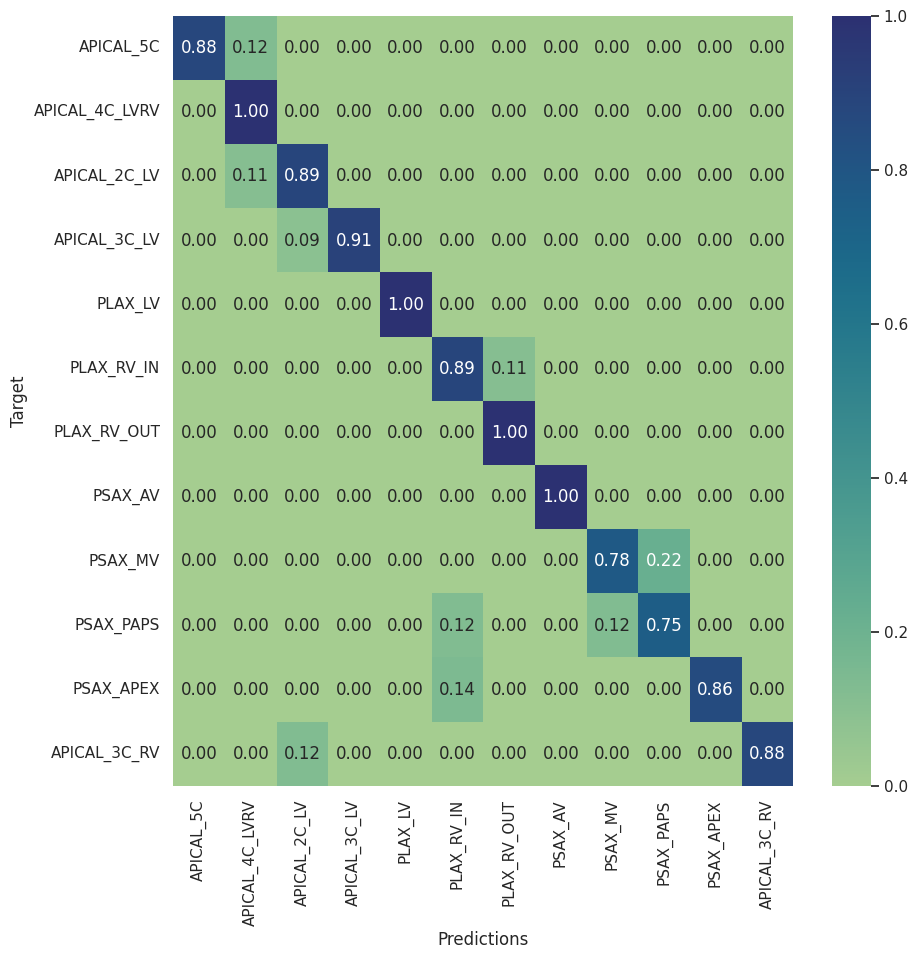

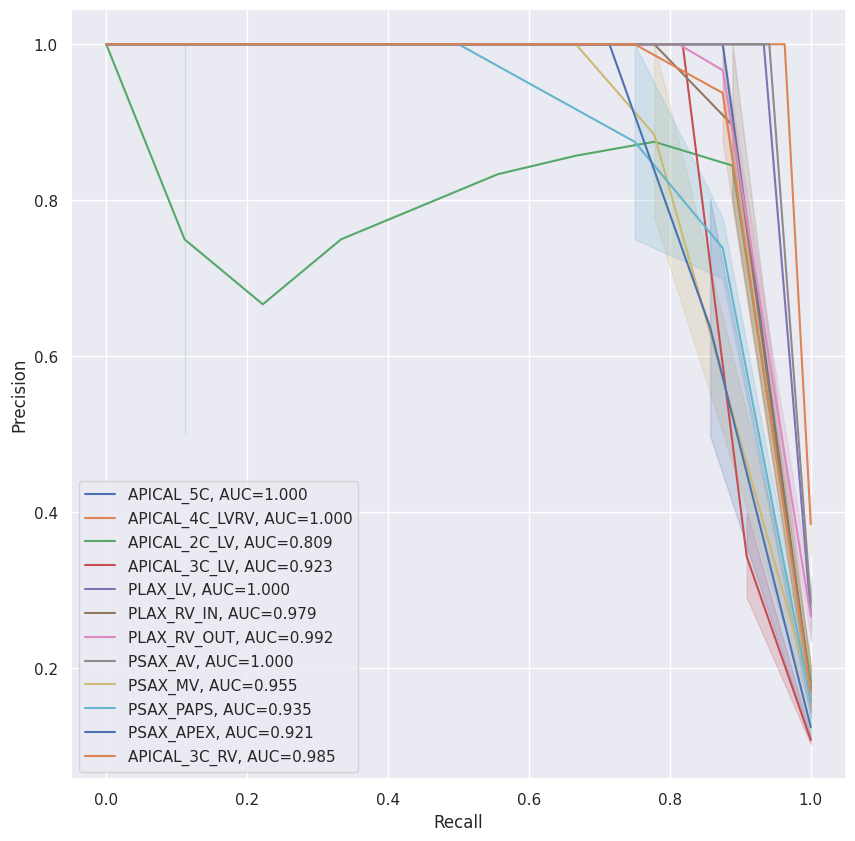

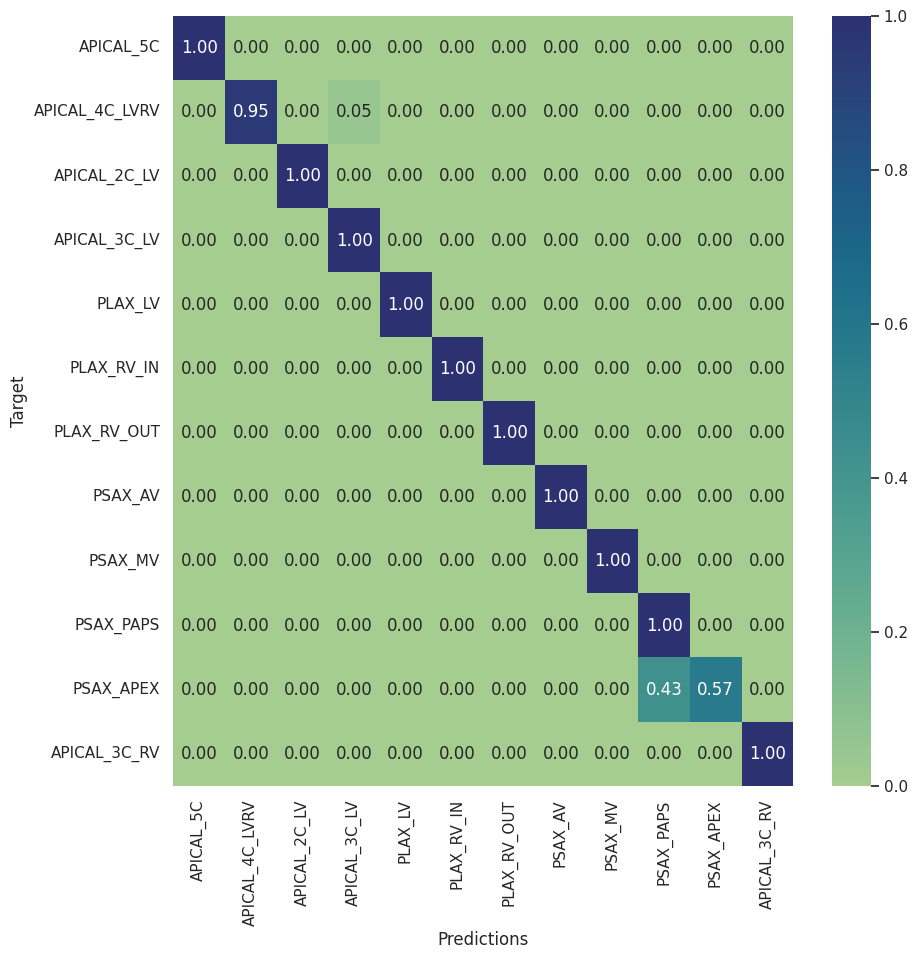

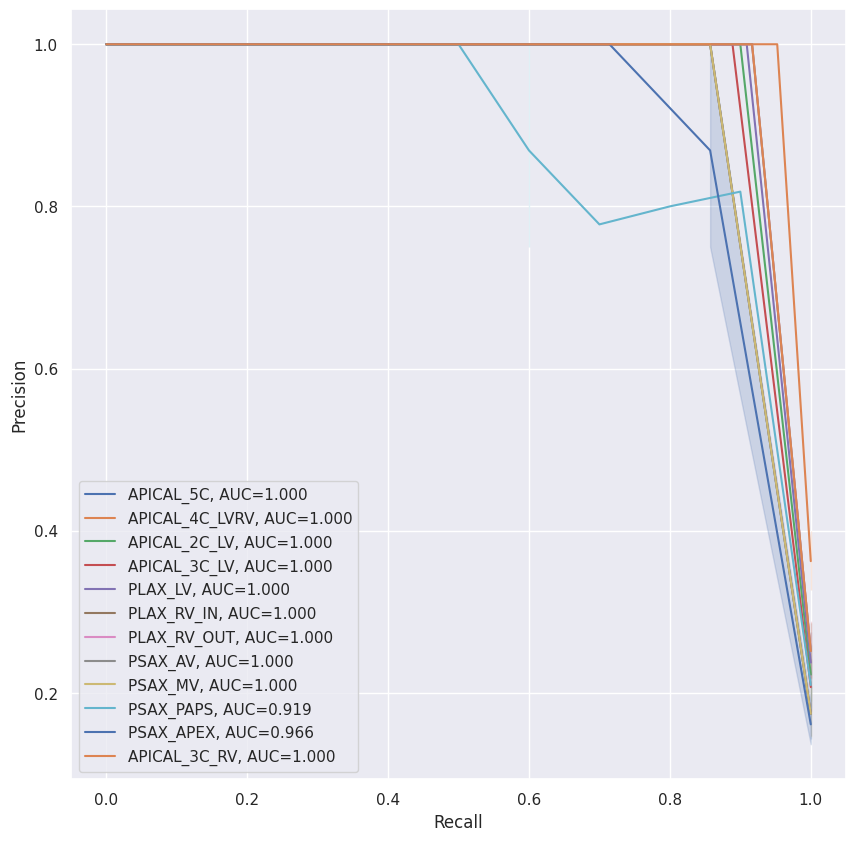

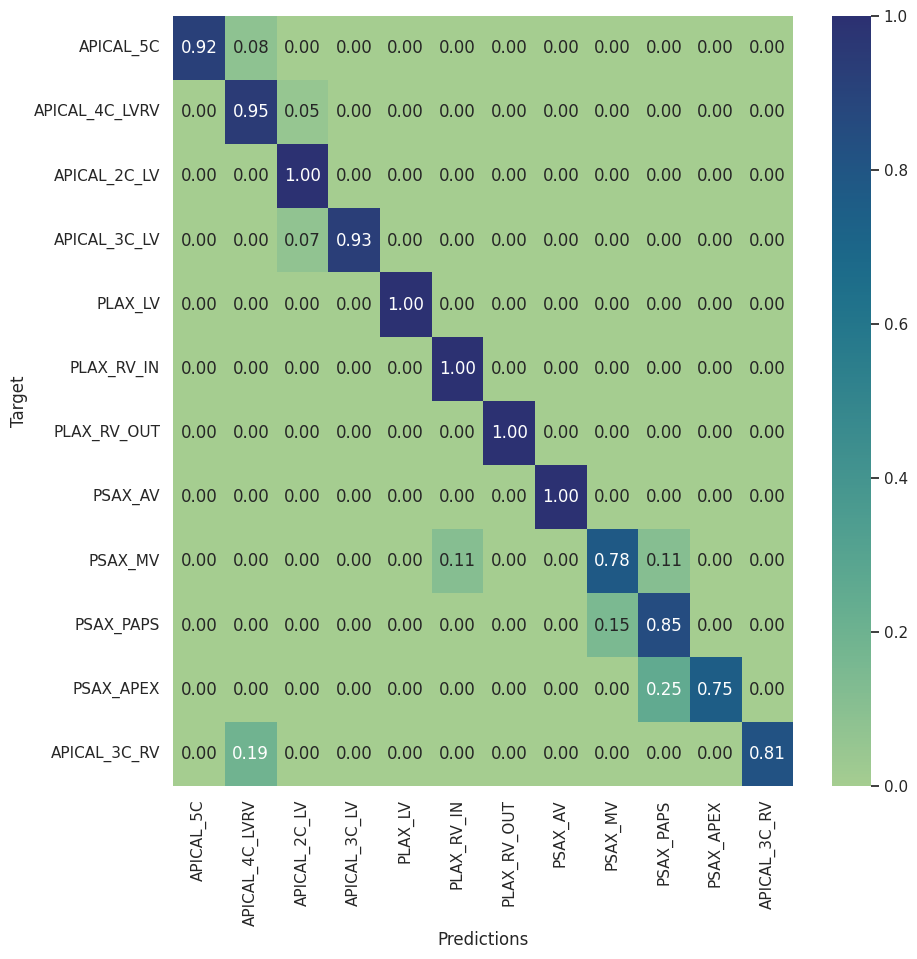

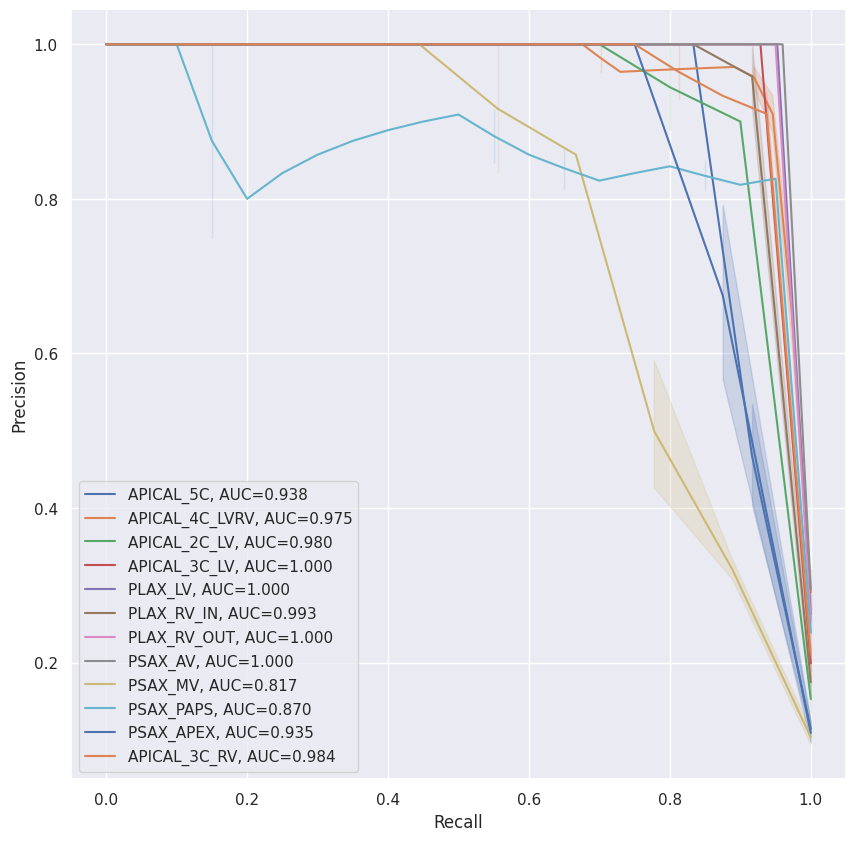

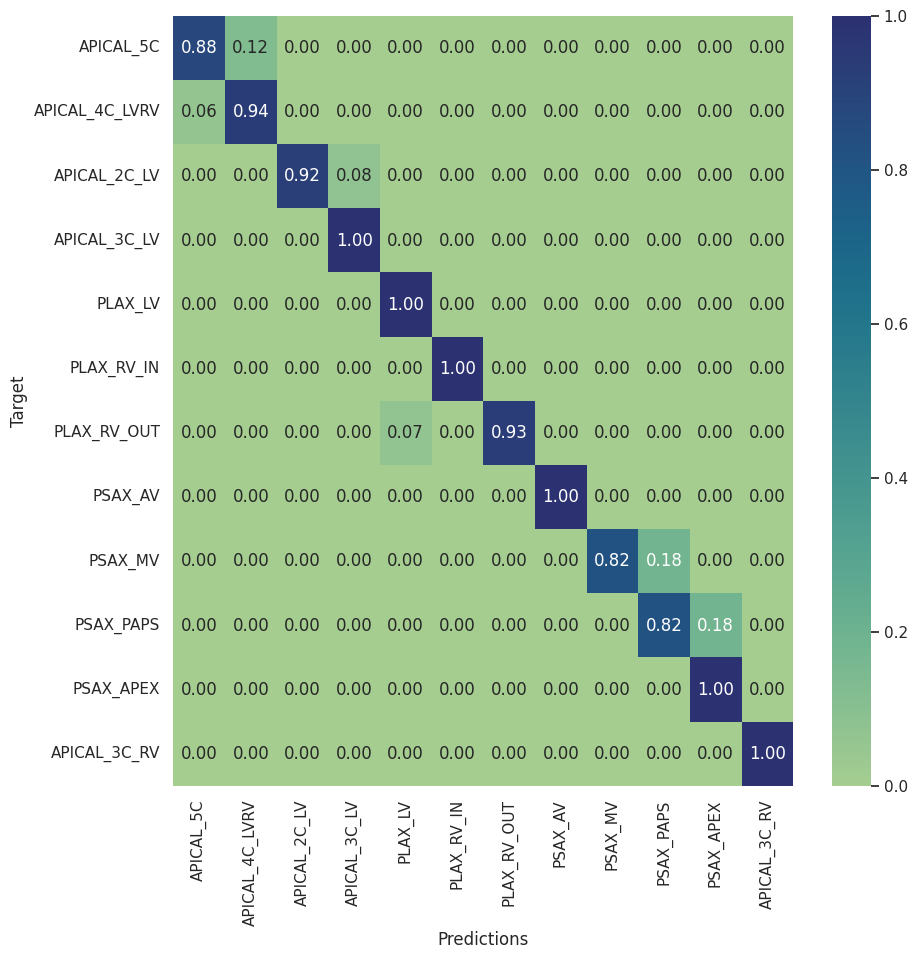

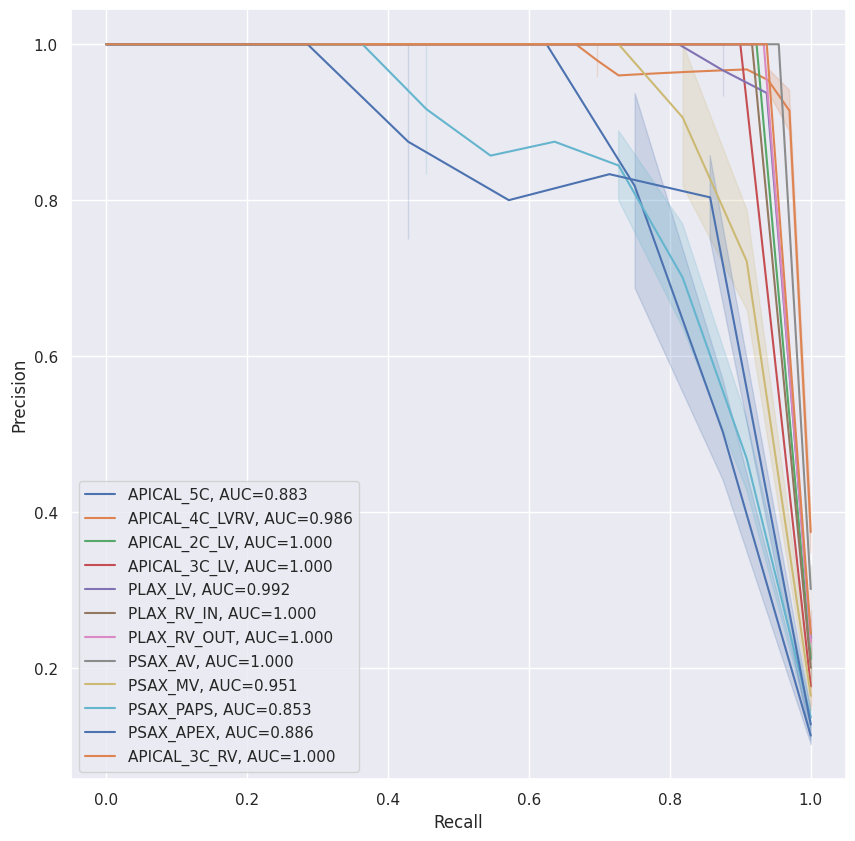

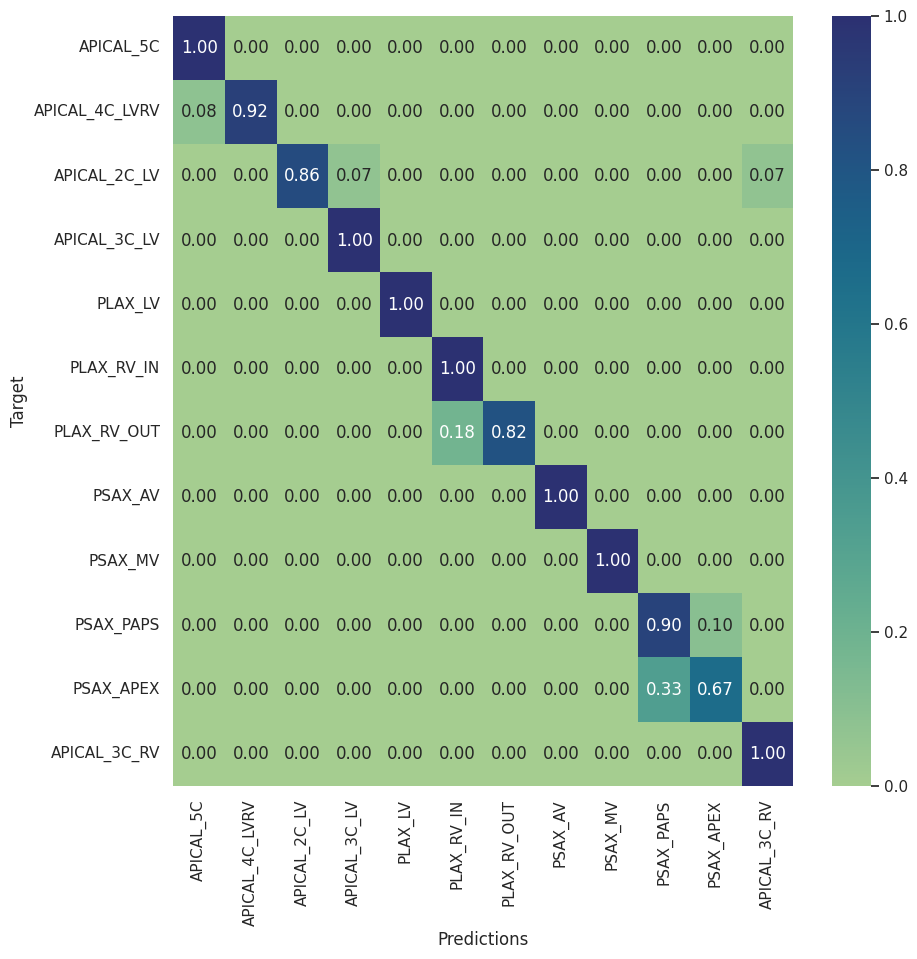

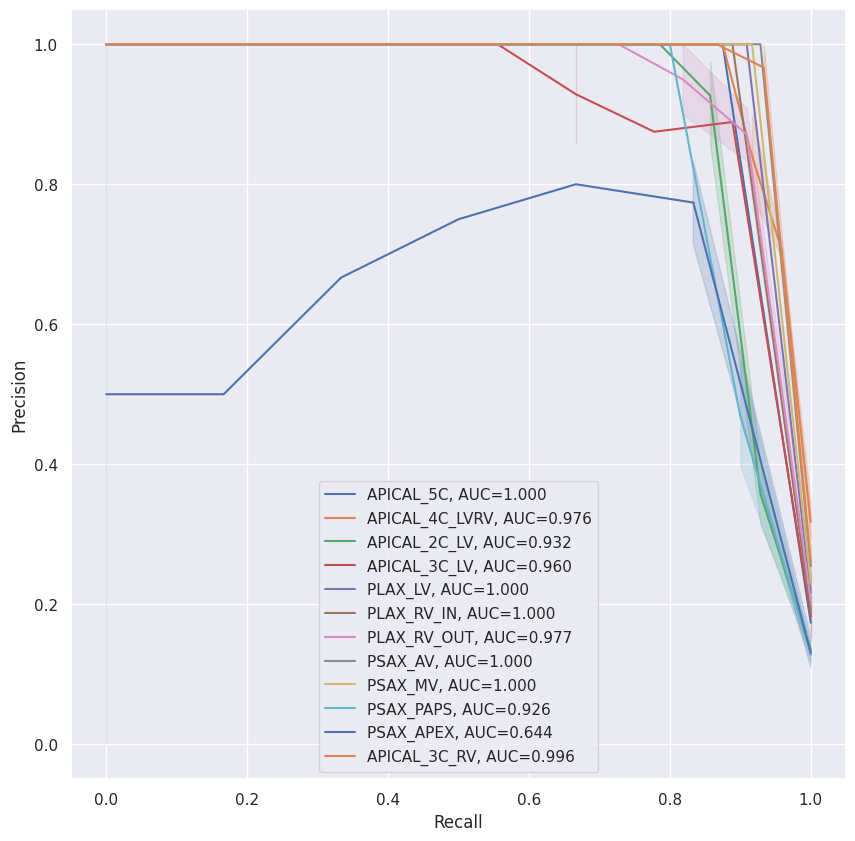

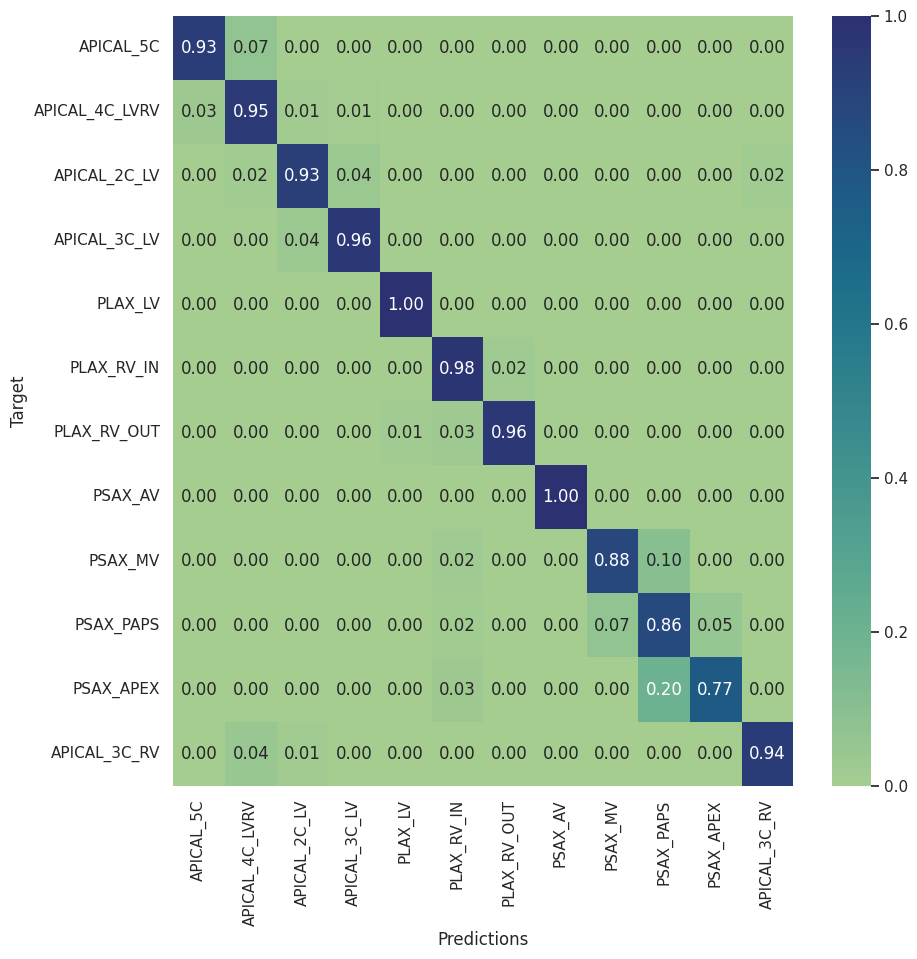

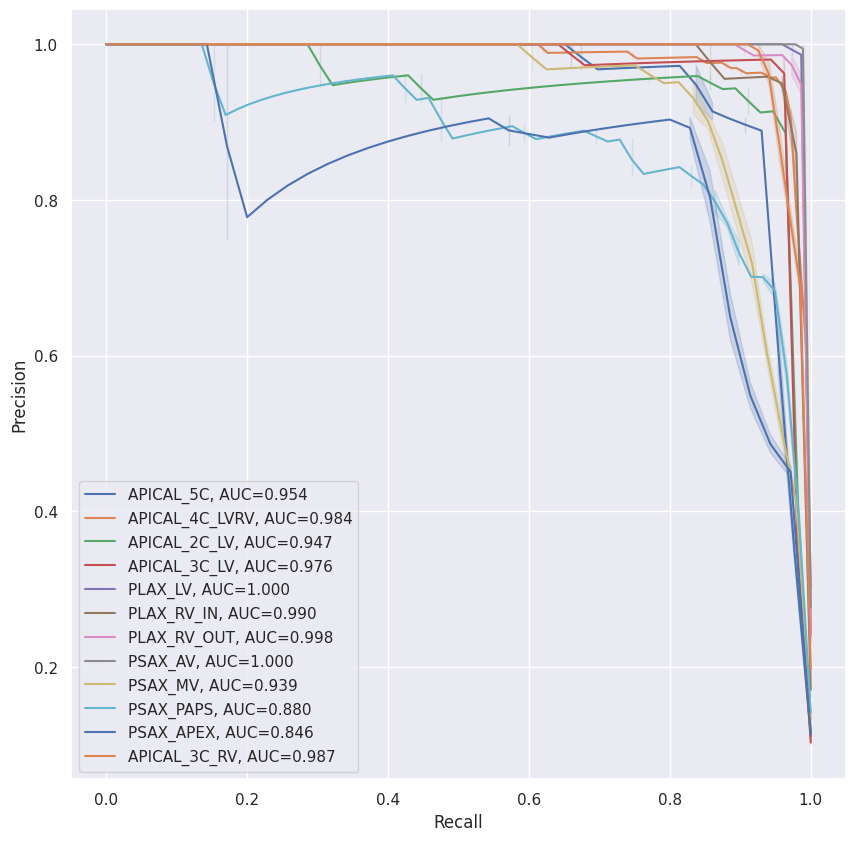

In [43]:

# Script has already been run, so need to read the json file and grab file names
# Then iterate through them and pass each to run via config?
# Then find a way to aggregate Fold-wide metrics

with open("./neo_echoset/folded_data.pkl", "rb") as f:
    data_folds = pickle.load(f)

# Create metrics to track across folds
fold_metrics = MetricCollection([
        MulticlassAccuracy(K), MulticlassPrecision(K), MulticlassRecall(K),
        MulticlassF1Score(K)
    ])

fold_confmat = MulticlassConfusionMatrix(K, normalize='true')
fold_pr = MulticlassPrecisionRecallCurve(K)

# Add paths to your checkpoints here!
# If not using wandb, could use regular file paths, modify the path in run()

# Colour CKPTS
# resnet_folded_ckpts = [
#   'lynerlabs/resnet-50-echo/model-7cedxcml:v0',
#   'lynerlabs/resnet-50-echo/model-udsiuio7:v0',
#   'lynerlabs/resnet-50-echo/model-fb5jvbup:v0',
#   'lynerlabs/resnet-50-echo/model-ngpls6nu:v0',
#   'lynerlabs/resnet-50-echo/model-lmk2dg74:v0',
# ]

resnet_folded_ckpts = [
  'lynerlabs/resnet-50-echo/model-8xqfb6va:v0',
  'lynerlabs/resnet-50-echo/model-csoffb6z:v0',
  'lynerlabs/resnet-50-echo/model-co1rol6j:v0',
  'lynerlabs/resnet-50-echo/model-bol7s0wl:v0',
  'lynerlabs/resnet-50-echo/model-5sv9obx4:v0',
]

# # 16 class checkpoints 
# resnet_folded_ckpts = [
#   'lynerlabs/resnet-50-echo/model-gt7b7rob:v0',
#   'lynerlabs/resnet-50-echo/model-7e3kce75:v0',
#   'lynerlabs/resnet-50-echo/model-enqp3sol:v0',
#   'lynerlabs/resnet-50-echo/model-h27khter:v0',
#   'lynerlabs/resnet-50-echo/model-swie5erh:v0',
# ]

for i, (train_path, valid_path) in enumerate(data_folds):
  params.fold = i
  params.train_path= train_path
  params.valid_path = valid_path
  params.metrics = fold_metrics
  params.confmat = fold_confmat
  params.pr = fold_pr

  # set resnet pretrained model from correct fold
  params.resnet_ckpt = resnet_folded_ckpts[i]

  print(f"Running fold #{i}..")
  run(config=params, project_name="delta-test")
  wandb.finish()

# Compute Fold Metrics

metrics = fold_metrics.compute()
confmat = fold_confmat.compute()

print(metrics)

with open("./metrics.txt", "w") as m:
    m.writelines(str(metrics))

fig_conf, ax_conf = plt.subplots(figsize=(10,10))
sns.heatmap(confmat.cpu(),
            cmap='crest',
            ax=ax_conf,
            annot=True,
            fmt=".2f",
            xticklabels=labels_list,
            yticklabels=labels_list)

ax_conf.set(xlabel="Predictions", ylabel="Target")
fig_conf.savefig('kconf.png', bbox_inches="tight")

pr = fold_pr.compute()
y, x = pr[:2]

fig_pr, ax_pr = plt.subplots(figsize=(10,10))

for i, (x_, y_) in enumerate(zip(x, y)):
  auc = torch.trapezoid(y_, x_, axis=-1)*-1
  auc = auc.detach().cpu().numpy()
  label = labels_list[i] + ", AUC={:.3f}".format(auc)
  sns.lineplot(x=x_.detach().cpu(), y=y_.detach().cpu(), ax=ax_pr, legend='full', label=label)

ax_pr.set(xlabel="Recall", ylabel="Precision")
fig_pr.savefig('kpr.png', bbox_inches="tight")


### Le Fin

## wandb.finish()